**Target**:
> 1.   Prepare the skeleton structure
2.   Apply transformations on dataset
3.   Prepare convolution and transition blocks instead of single layers.
4.   Test the model on single image and batch of images
5.   Record the basic flow



**Results**:

> 1.   Parameters: 43994
2.   Best Training Accuracy: 98.135%
3.   Best Test Accuracy: 98.08%





**Analysis**:

> 1.   Too many parameters than what is required
2.   Model is over-fitting and accuracy is not upto the mark















In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
train_set = torchvision.datasets.MNIST(root='/Data',
                                       train = True,
                                       download = True,
                                       transform=transforms.Compose([
                                                                     transforms.ToTensor(),
                                                                     
                                       ]),
                                       )
test_set = torchvision.datasets.MNIST(root='/Data',
                                       train = False,
                                       download = True,
                                       transform=transforms.Compose([
                                                                     transforms.ToTensor(),
                                                                     
                                       ]),
                                       )

In [ ]:
print(f"""Shape: {train_set.data.shape}
Minimum: {torch.min(train_set.transform(train_set.data.numpy()))}
Maximum: {torch.max(train_set.transform(train_set.data.numpy()))}
Mean: {torch.mean(train_set.transform(train_set.data.numpy()))}
Standard Deviation: {torch.std(train_set.transform(train_set.data.numpy()))}
Variance : {torch.var(train_set.transform(train_set.data.numpy()))}""")


Shape: torch.Size([60000, 28, 28])
Minimum: 0.0
Maximum: 1.0
Mean: 0.13066047430038452
Standard Deviation: 0.30810782313346863
Variance : 0.09493042528629303


In [ ]:
train_set.transform = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.13066047430038452,),(0.30810782313346863,))
                                        ])
test_set.transform =  transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.13066047430038452,),(0.30810782313346863,))
                                        ])


In [ ]:
train_set.transform , test_set.transform

(Compose(
     ToTensor()
     Normalize(mean=(0.13066047430038452,), std=(0.30810782313346863,))
 ), Compose(
     ToTensor()
     Normalize(mean=(0.13066047430038452,), std=(0.30810782313346863,))
 ))

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset = train_set,
                                           batch_size = 128,
                                           shuffle = True,
                                           pin_memory = True)
test_loader = torch.utils.data.DataLoader(dataset = test_set, 
                                          batch_size = 128,
                                          shuffle = True,
                                          pin_memory = True)

In [ ]:
images, labels = next(iter(train_loader))

In [ ]:
grid = torchvision.utils.make_grid(images, nrow=20)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


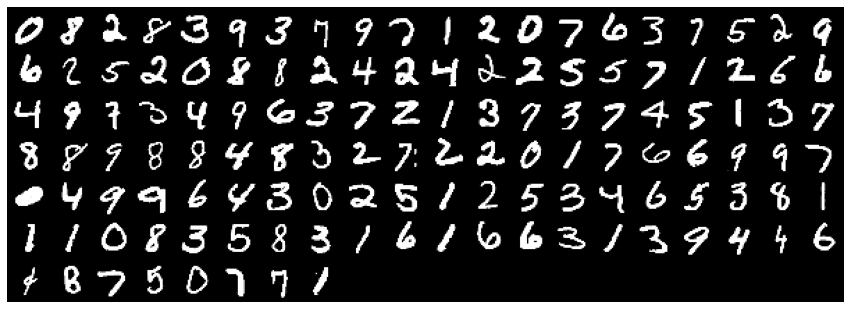

In [ ]:
plt.figure(figsize = (15,15))
plt.imshow(np.transpose(grid, (1,2,0)), cmap = 'gray')
plt.axis('off')
plt.show()

In [ ]:
class CustomModel(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv_Block1 = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size = 3, bias = False),
        nn.ReLU()
    ) # Output size = 26
    self.conv_Block2 = nn.Sequential(
        nn.Conv2d(in_channels = 10, out_channels = 32, kernel_size = 3, bias = False),
        nn.ReLU()
    ) # Output size = 24
    self.conv_Block3 = nn.Sequential(
        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, bias = False),
        nn.ReLU()
    ) # Output size = 22
    self.transition_block1 = nn.Sequential(
        nn.MaxPool2d(kernel_size = 2, stride = 2),
        nn.Conv2d(in_channels = 64, out_channels = 10, kernel_size = 1, bias = False)
    ) # Output size = 11    
    self.conv_Block4 = nn.Sequential(
        nn.Conv2d(in_channels = 10, out_channels = 32, kernel_size = 3, bias = False),
        nn.ReLU()
    ) # Output size = 9
    self.conv_Block5 = nn.Sequential(
        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, bias = False),
        nn.ReLU()
    ) # Output size = 7    
    self.transition_block2 = nn.Sequential(
        nn.MaxPool2d(kernel_size = 2, stride = 2),
        nn.Conv2d(in_channels = 64, out_channels = 10, kernel_size = 1, bias = False)
    ) # Output size = 3
    self.gap = nn.AvgPool2d(kernel_size = 3) # Output size = 1

  def forward(self, image):
    image = self.conv_Block3(self.conv_Block2(self.conv_Block1(image)))    
    image = self.transition_block1(image)
    image = self.conv_Block5(self.conv_Block4(image))
    image = self.transition_block2(image)
    image = self.gap(image)
    image = image.reshape(-1,10)
    return F.log_softmax(image, dim=-1)




In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available() # check if GPU available
device = torch.device("cuda" if use_cuda else "cpu") # use cpu if gpu is not available
model = CustomModel().to(device) 
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
            Conv2d-3           [-1, 32, 24, 24]           2,880
              ReLU-4           [-1, 32, 24, 24]               0
            Conv2d-5           [-1, 64, 22, 22]          18,432
              ReLU-6           [-1, 64, 22, 22]               0
         MaxPool2d-7           [-1, 64, 11, 11]               0
            Conv2d-8           [-1, 10, 11, 11]             640
            Conv2d-9             [-1, 32, 9, 9]           2,880
             ReLU-10             [-1, 32, 9, 9]               0
           Conv2d-11             [-1, 64, 7, 7]          18,432
             ReLU-12             [-1, 64, 7, 7]               0
        MaxPool2d-13             [-1, 64, 3, 3]               0
           Conv2d-14             [-1, 1

In [ ]:
print(next(iter(model.parameters())),next(iter(model.parameters())).shape)

Parameter containing:
tensor([[[[-0.2480,  0.2860,  0.2128],
          [-0.1981,  0.2573,  0.0349],
          [-0.1271, -0.1299,  0.2905]]],


        [[[ 0.0465,  0.2073,  0.1681],
          [-0.0804, -0.0693, -0.0023],
          [-0.1030, -0.2382, -0.1436]]],


        [[[-0.2317, -0.1781,  0.1728],
          [-0.0809, -0.1021,  0.1767],
          [-0.0409, -0.0573, -0.1180]]],


        [[[ 0.2433,  0.1913, -0.0391],
          [ 0.2017, -0.1706,  0.1407],
          [ 0.0602,  0.2819, -0.0601]]],


        [[[-0.2438,  0.0986, -0.1556],
          [-0.1319,  0.2425,  0.2210],
          [-0.2530,  0.0702, -0.0839]]],


        [[[-0.0502,  0.1791, -0.2246],
          [ 0.2905,  0.1957,  0.1980],
          [-0.1277, -0.1432,  0.0380]]],


        [[[-0.1629, -0.3211, -0.0852],
          [-0.2352, -0.1380, -0.3137],
          [-0.1356,  0.1315,  0.0788]]],


        [[[ 0.3067,  0.2449,  0.1347],
          [-0.0803,  0.3034, -0.1978],
          [-0.0548,  0.1697, -0.1546]]],


        [[

# Testing the model on one image

In [ ]:
image, label = next(iter(train_loader))


In [ ]:
pred = model(image[0].unsqueeze(0).to(device))

In [ ]:
pred

tensor([[-2.3057, -2.2957, -2.3013, -2.2990, -2.2998, -2.3083, -2.3116, -2.3041,
         -2.3025, -2.2980]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)

In [ ]:
print(pred.squeeze())
print(torch.argmax(pred.squeeze()))
print(label[0])

tensor([-2.3057, -2.2957, -2.3013, -2.2990, -2.2998, -2.3083, -2.3116, -2.3041,
        -2.3025, -2.2980], device='cuda:0', grad_fn=<SqueezeBackward0>)
tensor(1, device='cuda:0')
tensor(7)


In [ ]:
loss = F.nll_loss(pred, label[0].unsqueeze(0).to(device))
print(loss.item())

2.304060935974121


In [ ]:
pred.argmax().eq(label[0].view_as(pred.argmax()))

tensor(False, device='cuda:0')

# Testing the model on one batch

In [ ]:
batch = next(iter(train_loader))
images1, labels1 = batch
images1, labels1 = images1.to(device), labels1.to(device)
pred1 = model(images1)


In [ ]:
loss1 = F.nll_loss(pred1, labels1)

In [ ]:
print(f'Loss : {loss1.item()}')

Loss : 2.3025879859924316


In [ ]:
print(f'Total Correct : {pred1.argmax(dim=1).eq(labels1.view_as(pred1.argmax(dim=1))).sum().item()}')

Total Correct : 19


In [ ]:
optimiser = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
loss1.backward()
optimiser.step()

In [ ]:
batch = next(iter(train_loader))
images2, labels2 = batch
images2, labels2 = images2.to(device), labels2.to(device)
pred2 = model(images2)


In [ ]:
loss2 = F.nll_loss(pred2, labels2)
print(f'Loss : {loss2.item()}')

Loss : 2.302096366882324


In [ ]:
print(f'Total Correct: {pred2.argmax(dim=1).eq(labels2.view_as(pred2.argmax(dim=1))).sum().item()}')

Total Correct: 20


# Training the entire set

In [ ]:
def train_model(model, device, train_loader, optimiser):
  train_loss, train_accuracy, total_train_correct, total_train_processed = 0, 0, 0, 0    
  
  for batch in train_loader: 
    images, labels = batch
    images, labels = images.to(device), labels.to(device) 
    optimiser.zero_grad()

    pred = model(images)
    pred_values = pred.argmax(dim=1, keepdim=True)
    loss = F.nll_loss(pred, labels)
    train_loss += loss.item()

    loss.backward()
    optimiser.step()       
    
    total_train_correct += pred_values.eq(labels.view_as(pred_values)).sum().item()
    total_train_processed += len(images)
    
  train_accuracy = 100*(total_train_correct/total_train_processed)
  train_loss /= len(train_loader.dataset) 
  return train_loss, train_accuracy  



def test_model(model, device, test_loader):
  test_loss, test_accuracy, total_test_correct, total_test_processed = 0, 0, 0, 0    
  
  for batch in test_loader: 
    images, labels = batch
    images, labels = images.to(device), labels.to(device) 
    
    pred = model(images)
    pred_values = pred.argmax(dim=1, keepdim=True)
    loss = F.nll_loss(pred, labels)
    test_loss += loss.item()          
    
    total_test_correct += pred_values.eq(labels.view_as(pred_values)).sum().item()
    total_test_processed += len(images)
    
  test_accuracy = 100*(total_test_correct/total_test_processed)
  test_loss /= len(test_loader.dataset) 
  return test_loss, test_accuracy
  





In [ ]:
optimiser = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
def train_epochs(epochs):
  train_losses, train_accuracies, test_losses, test_accuracies = [], [], [], []
  for epoch in range(epochs):
    print(f"Epoch {epoch+1} in progress....")
    train_loss, train_accuracy = train_model(model, device, train_loader, optimiser)
    test_loss, test_accuracy = test_model(model, device, test_loader)
    print(f"\nEpoch : {epoch+1} \n\nAverage Train Loss : {train_loss :.9f} \nTrain Accuracy : {train_accuracy : .4f}% \n\nAverage Test Loss : {test_loss :.9f} \nTest Accuracy : {test_accuracy : .4f}% \n\n")
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
  return train_losses, train_accuracies, test_losses, test_accuracies
  

In [ ]:
train_losses, train_accuracies, test_losses, test_accuracies = train_epochs(10)

Epoch 1 in progress....

Epoch : 1 

Average Train Loss : 0.012023257 
Train Accuracy :  43.4133% 

Average Test Loss : 0.001818820 
Test Accuracy :  92.6900% 


Epoch 2 in progress....

Epoch : 2 

Average Train Loss : 0.001494691 
Train Accuracy :  94.1350% 

Average Test Loss : 0.001134776 
Test Accuracy :  95.6800% 


Epoch 3 in progress....

Epoch : 3 

Average Train Loss : 0.001044835 
Train Accuracy :  95.7967% 

Average Test Loss : 0.000797586 
Test Accuracy :  96.9100% 


Epoch 4 in progress....

Epoch : 4 

Average Train Loss : 0.000827003 
Train Accuracy :  96.7633% 

Average Test Loss : 0.000812714 
Test Accuracy :  96.8000% 


Epoch 5 in progress....

Epoch : 5 

Average Train Loss : 0.000732691 
Train Accuracy :  97.1967% 

Average Test Loss : 0.000606376 
Test Accuracy :  97.5700% 


Epoch 6 in progress....

Epoch : 6 

Average Train Loss : 0.000670584 
Train Accuracy :  97.3767% 

Average Test Loss : 0.000688707 
Test Accuracy :  97.0900% 


Epoch 7 in progress....

Epo

Text(0.5, 1.0, 'Test Accuracy')

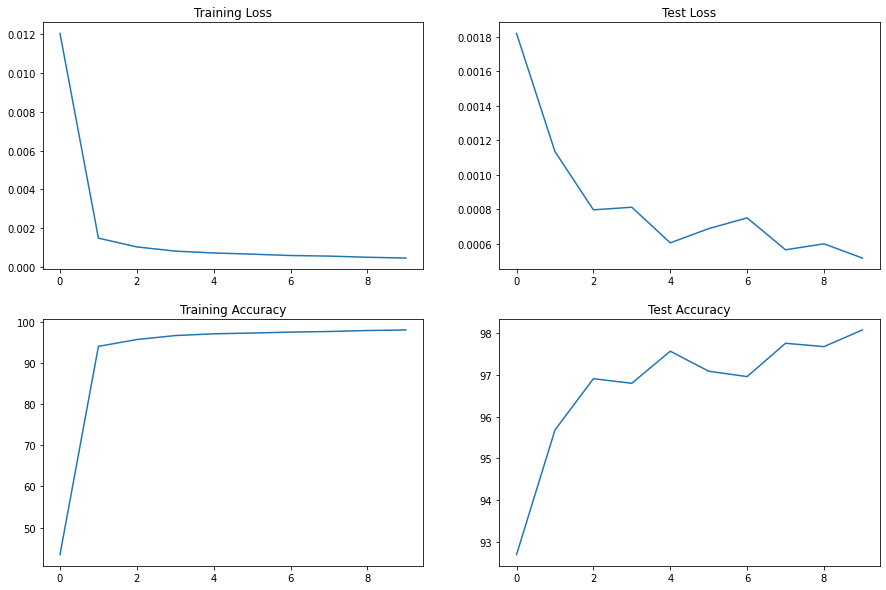

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_accuracies)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_accuracies)
axs[1, 1].set_title("Test Accuracy")